In [11]:
from typing import Dict, List
import matplotlib.pyplot as plt
import networkx as nx
import overpy
import numpy as np
from operator import itemgetter

In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
from scripts.config import Config

In [14]:
def eval_way(way, config: Config = Config()):
    score = 0
    max_score = config.weight_sum()
    for tag, value in way.tags.items():
        weight, mapping = config[tag]
        score += weight * mapping.get(value, 0)
    return score / max_score

In [15]:
def filter_ways(result, threshold):
    ways = []
    for way in result.ways:
        score = eval_way(way)
        if way.id == 158699739:
            print(score)
        if score > threshold:
            ways.append(way)
    return ways

In [16]:
def node_in_area(node: overpy.Node, config: Config):
    south, west, north, east = config.bounding_box.South, config.bounding_box.West, \
        config.bounding_box.North, config.bounding_box.East
    lon, lat = float(node.lon), float(node.lat)
    return (lon <= east) and (lon >= west) and (lat >= south) and (lat <= north)

In [17]:
def ways_to_edges(ways: List[overpy.Way], config: Config = Config()):
    link_counter: Dict[str, int] = {}
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        for node in nodes:
            link_counter[node.id] = link_counter.get(node.id, 0) + 1

    edges = []
    all_nodes = set()
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        nodes = [node for node in nodes if node_in_area(node, config)]
        if len(nodes) == 2:
            edges.append([nodes[0].id, nodes[1].id])  # add way as an edge
            all_nodes.add(nodes[0])
            all_nodes.add(nodes[1])
            continue
        head = nodes[0]
        tail = nodes[len(nodes) - 1]
        prev = head
        for i in range(1, len(nodes)):
            node = nodes[i]
            if (link_counter[node.id] > 1 or node is tail) and prev.id != node.id:
                edges.append([prev.id, node.id])
                all_nodes.add(prev)
                all_nodes.add(node)
                prev = node
    return edges, list(all_nodes)

In [18]:
api = overpy.Overpass()
# result = api.query("nwr(56.3284, -2.8350, 56.3437, -2.7855); out;")  # st andrews
result = api.query("nwr(56.3375, -2.8059, 56.3422, -2.7888); out;")

In [19]:
ways = filter_ways(result, 0.1)

0.19705882352941181


In [20]:
edges, all_nodes = ways_to_edges(ways)

In [21]:
ids = set([node.id for node in all_nodes])
print(261732339 in ids)

True


In [22]:
target = 261732339
for edge in edges:
    if edge[0] == edge[1]:
        print(edge)

In [23]:
layout = {node.id: (float(node.lon), float(node.lat)) for node in all_nodes}

In [24]:
G = nx.Graph(edges)

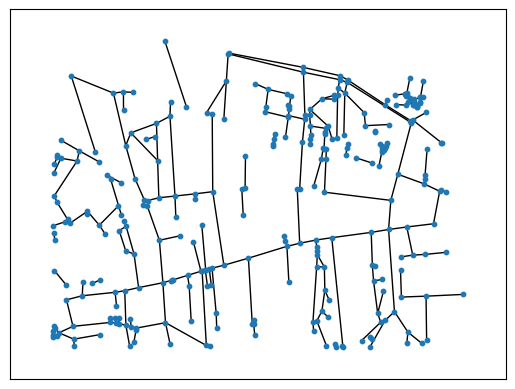

In [25]:
nx.draw_networkx(G, pos=layout, with_labels=False, node_size=10, font_size=6)

In [26]:
def poly_area(x,y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

In [27]:
def group_area(group, layout):
    coordinates = [layout.get(node_id) for node_id in group]
    south = min(coordinates, key=lambda x: x[1])
    west = min(coordinates, key=lambda x: x[0])
    north = max(coordinates, key=lambda x: x[1])
    east = max(coordinates, key=lambda x: x[0])
    bbox = [south, west, north, east]
    return poly_area([n[0] for n in bbox], [n[1] for n in bbox])

In [28]:
sorted_groups = sorted(nx.connected_components(G), key=lambda g: group_area(g, layout), reverse=True)
len(sorted_groups[0])

199

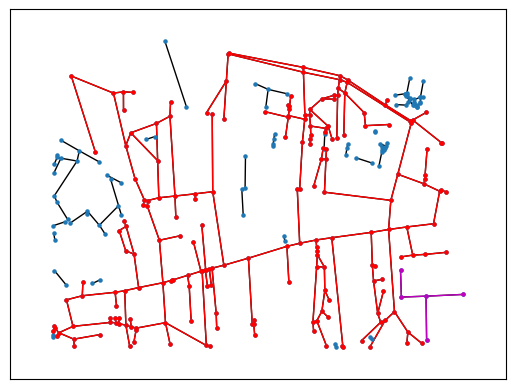

In [32]:
largest_component = G.subgraph(list(sorted_groups[0]))
second_component = G.subgraph(list(sorted_groups[1]))
nx.draw_networkx(G, pos=layout, with_labels=False, \
                 node_size=5)
nx.draw_networkx(largest_component, pos=layout, \
                 with_labels=False, node_size=5, \
                 node_color='r', edge_color='r', font_size=6)
nx.draw_networkx(second_component, pos=layout, \
                 with_labels=False, node_size=5, \
                 node_color='m', edge_color='m', font_size=6)